In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns

from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from centralized import HeartDiseaseNN as EvaluatorModel


In [2]:
torch.manual_seed(42)
np.random.seed(42)
seed = 42

In [3]:
class BottomModel(nn.Module):
    def __init__(self, in_feat, out_feat):
        super(BottomModel, self).__init__()
        self.local_out_dim = out_feat
        self.fc1 = nn.Linear(in_feat, out_feat)
        self.fc2 = nn.Linear(out_feat, out_feat)
        self.act = nn.ReLU()
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.act(self.fc1(x))
        return self.dropout(self.act(self.fc2(x)))
    
class TopModel(nn.Module):
    def __init__(self, local_models, n_outs):
        super(TopModel, self).__init__()
        self.in_size = sum([local_models[i].local_out_dim for i in range(len(local_models))])
        self.fc1 = nn.Linear(self.in_size, 128)
        self.fc2 = nn.Linear(128, 256)
        self.fc3 = nn.Linear(256, 2)
        self.act = nn.LeakyReLU()
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        concat_outs = torch.cat(x, dim=1)  # concatenate local model outputs before forward pass
        x = self.act(self.fc1(concat_outs))
        x = self.act(self.fc2(x))
        x = self.act(self.fc3(x))
        return self.dropout(x)
    
class VFLNetwork(nn.Module):
    def __init__(self, local_models, n_outs):
        super(VFLNetwork, self).__init__()
        self.num_cli = None  # the number of clients
        self.cli_features = None  # the set of features corresponding to a client
        self.bottom_models = local_models
        self.top_model = TopModel(self.bottom_models, n_outs)
        self.optimizer = optim.AdamW(self.parameters())
        self.criterion = nn.CrossEntropyLoss()

    def train_with_settings(self, epochs, batch_sz, n_cli, cli_features, x, y):
        self.num_cli = n_cli  
        self.cli_features = cli_features  
        x = x.astype('float32')
        y = y.astype('float32')
        x_train = [torch.tensor(x[feats].values) for feats in cli_features]
        y_train = torch.tensor(y.values)

        loss_list = torch.zeros(epochs)

        num_batches = len(x) // batch_sz if len(x) % batch_sz == 0 else len(x) // batch_sz + 1
        for epoch in range(epochs):
            self.optimizer.zero_grad()
            total_loss = 0.0
            correct = 0.0
            total = 0.0
            for minibatch in range(num_batches):
                if minibatch == num_batches - 1:
                    x_minibatch = [x[int(minibatch * batch_sz):] for x in x_train]
                    y_minibatch = y_train[int(minibatch * batch_sz):]
                else:
                    x_minibatch = [x[int(minibatch * batch_sz):int((minibatch + 1) * batch_sz)] for x in x_train]
                    y_minibatch = y_train[int(minibatch * batch_sz):int((minibatch + 1) * batch_sz)]

                outs = self.forward(x_minibatch)
                pred = torch.argmax(outs, dim=1)
                actual = torch.argmax(y_minibatch, dim=1)
                correct += torch.sum((pred == actual))
                total += len(actual)
                loss = self.criterion(outs, y_minibatch)
                total_loss += loss
                loss.backward()
                self.optimizer.step()
                
            loss_list[epoch] = total_loss / num_batches
            
        return loss_list

    def forward(self, x):
        local_outs = [self.bottom_models[i](x[i]) for i in range(len(self.bottom_models))]
        return self.top_model(local_outs)

    def test(self, x, y):
        x = x.astype('float32')
        y = y.astype('float32')
        x_test = [torch.tensor(x[feats].values) for feats in self.cli_features]
        y_test = torch.tensor(y.values)
        with torch.no_grad():
            outs = self.forward(x_test)
            preds = torch.argmax(outs, dim=1)
            actual = torch.argmax(y_test, dim=1)
            accuracy = torch.sum((preds == actual)) / len(actual)
            loss = self.criterion(outs, y_test)
            return accuracy, loss

# Homework - Vertical FL and Generative Modeling
Vertical federated learning (VFL) and generative modeling are two techniques for privacy preservation. The former enables collaborative training across vertically partitioned data. At the same time, generative modeling creates synthetic data as an alternative to using real sensitive data. In this assignment, you'll further explore some factors affecting model performance in VFL and how it can be bridged with generative modeling. 



# Instructions

Submit your assignment as a Jupyter notebook with all relevant execution outputs and plots visible. Clearly indicate the relevant steps in your code, such as data preprocessing, model definition, training, etc. Partial grades can be given for incomplete problems provided the steps are clearly indicated.

## Question 1: Feature permutation in VFL (4 points)

Using the template code from [lab_vfl.ipynb](https://github.com/lydiaYchen/DDL24Spring/blob/main/lab/lab-vfl.ipynb), experiment with how shuffling the order of feature assignments to clients affects the performance. Use 4 clients with the default hyperparameters. Experiment with **5** random feature permutations and plot the training loss. Report whether shuffling features significantly affects the convergence rates and the reasoning behind it.

Scoring:
- _(1 point)_ Create 5 feature permutations (shuffling done before one-hot encoding) with seeded Python/NumPy random functions and run them through the discriminative VFL model.
- _(1 point)_ Log the losses over time of the training runs and compile them into one plot.
- _(2 points)_ State what impact (if any) the permutations have on the loss and explain the observed pattern.

In [4]:
df = pd.read_csv("heart-dataset/heart.csv")
num_clients = 4

In [5]:
#Training configurations
EPOCHS = 300
BATCH_SIZE = 64
TRAIN_TEST_THRESH = 0.8

# model architecture hyperparameters
outs_per_client = 2
final_out_dims = 2

categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
numerical_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
df[numerical_cols] = MinMaxScaler().fit_transform(df[numerical_cols])  # scale numerical features for effective learning

In [6]:
def get_x_y(categorical_cols):
    encoded_df = pd.get_dummies(df, columns=categorical_cols)  #convert categorical features to one-hot embeddings
    X = encoded_df.drop("target", axis=1)
    Y = pd.get_dummies(encoded_df[['target']], columns=['target'])
    return X, Y

In [7]:
def partition_features(df, X, num_clients, categorical_cols, all_feature_names):
    features_per_client = (num_clients - 1) * [(len(df.columns) - 1) // num_clients]  # "equally" partition the features
    features_per_client.append(len(df.columns) - 1 - sum(features_per_client))
    features_per_client = np.array(features_per_client)

    client_feature_names = []
    test_list = []
    csum_features_per_client = np.cumsum(features_per_client)
    encoded_df_feature_names = list(X.columns)
    start_index = 0
    end_index = 0
    for num_feats in features_per_client:
        feat_names = all_feature_names[start_index:start_index + num_feats]
        client_feature_names.append(feat_names)
        start_index = start_index + num_feats
    for i in range(len(client_feature_names)):
        updated_names = []
        for column_name in client_feature_names[i]:
            if column_name not in categorical_cols:
                updated_names.append(column_name)
            else:
                for name in encoded_df_feature_names:
                    if '_' in name and column_name in name:
                        updated_names.append(name)

        client_feature_names[i] = updated_names
    return client_feature_names

In [8]:
def build_vfl_network(client_feature_names, final_out_dims, outs_per_client):
    bottom_models = [BottomModel(len(in_feats), outs_per_client * len(in_feats)) for in_feats in client_feature_names]
    Network = VFLNetwork(bottom_models, final_out_dims)
    return Network

In [9]:
def train_test(X, Y):
    X_train, X_test = X.loc[:int(TRAIN_TEST_THRESH * len(X))], X.loc[int(TRAIN_TEST_THRESH * len(X)) + 1:]
    Y_train, Y_test = Y.loc[:int(TRAIN_TEST_THRESH * len(Y))], Y.loc[int(TRAIN_TEST_THRESH * len(Y)) + 1:]
    return X_train, X_test, Y_train, Y_test

In [10]:
def features_permutation(categorical_cols, numerical_cols):
    return np.random.permutation(categorical_cols).tolist(), np.random.permutation(numerical_cols).tolist()

In [11]:
all_loss_feature_shuffle = {}

In [12]:
all_feature_names = list(df.columns)
all_feature_names.pop()

X, Y = get_x_y(categorical_cols)

client_feature_names = partition_features(df=df,
                                          X=X,
                                          num_clients=num_clients,
                                          categorical_cols=categorical_cols,
                                          all_feature_names=all_feature_names)

Network = build_vfl_network(client_feature_names=client_feature_names,
                            final_out_dims=final_out_dims,
                            outs_per_client=outs_per_client)

X_train, X_test, Y_train, Y_test = train_test(X=X,
                                              Y=Y)

all_loss_feature_shuffle['Without permutation'] = Network.train_with_settings(EPOCHS, BATCH_SIZE,
                                   num_clients,
                                   client_feature_names,
                                   X_train,
                                   Y_train)

In [13]:
categorical_cols_shuffled, numerical_cols_shuffled = features_permutation(categorical_cols=categorical_cols,
                                                                            numerical_cols=numerical_cols)

for i in range(5):

    X, Y = get_x_y(categorical_cols_shuffled)

    client_feature_names = partition_features(df=df,
                                            X=X,
                                            num_clients=num_clients,
                                            categorical_cols=categorical_cols_shuffled,
                                            all_feature_names=categorical_cols_shuffled + numerical_cols_shuffled)

    #print(client_feature_names)

    Network = build_vfl_network(client_feature_names=client_feature_names,
                                final_out_dims=final_out_dims,
                                outs_per_client=outs_per_client)

    X_train, X_test, Y_train, Y_test = train_test(X=X,
                                                Y=Y)

    all_loss_feature_shuffle[f'With permutation {i}'] = Network.train_with_settings(EPOCHS, BATCH_SIZE,
                                    num_clients,
                                    client_feature_names,
                                    X_train,
                                    Y_train)
    
    categorical_cols_shuffled, numerical_cols_shuffled = features_permutation(categorical_cols=categorical_cols_shuffled,
                                                                            numerical_cols=numerical_cols_shuffled)


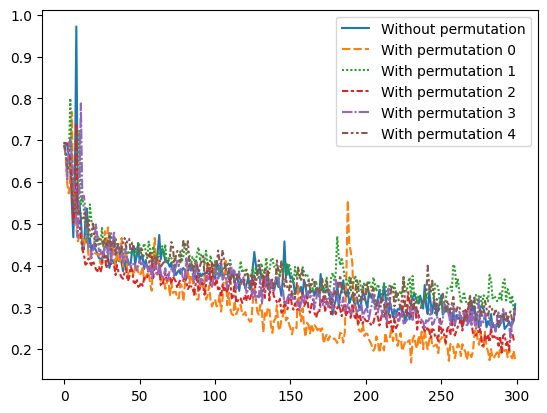

In [14]:
all_loss_feature_shuffle_np = {key: value.detach().numpy() for key, value in all_loss_feature_shuffle.items()}

df_loss_feature_shuffle = pd.DataFrame(all_loss_feature_shuffle_np)

ax = sns.lineplot(df_loss_feature_shuffle)

#### State what impact (if any) the permutations have on the loss and explain the observed pattern.

The permutations of the features can slightly impact the loss as some features permutations can be more or less correlated to the target feature.
We can also note that by using a dropout, it also brings noise to the model.

## Question 2: Scaling clients in VFL (4 points)

With the same template code, experiment with how increasing the number of clients affects model performance. Plot the training loss with 2, 4, and 8 clients. Try a greedy partition for the features, with the remaining extra features assigned to the last client. For example, with 14 features and three clients, assign four features to clients 1 and 2 and six to client 3. Report your reasoning for the observed output.

Scoring:
- _(1 point)_ Create the greedily-partitioned feature splits for the requested client counts (use the default ordering in the dataset) and run them through the discriminative VFL model.
- _(1 point)_ Log the losses over time of the training runs and compile them into one plot.
- _(2 points)_ State what impact (if any) adding more clients has on the loss and explain the observed pattern.

In [15]:
nb_clients = [2, 4, 8]
all_loss_clients = {}

In [16]:
for nb_client in nb_clients:
    X, Y = get_x_y(categorical_cols)

    client_feature_names = partition_features(df=df,
                                            X=X,
                                            num_clients=nb_client,
                                            categorical_cols=categorical_cols,
                                            all_feature_names=all_feature_names)

    Network = build_vfl_network(client_feature_names=client_feature_names,
                                final_out_dims=final_out_dims,
                                outs_per_client=outs_per_client)

    X_train, X_test, Y_train, Y_test = train_test(X=X,
                                                Y=Y)

    all_loss_clients[f'{nb_client} clients'] = Network.train_with_settings(EPOCHS, BATCH_SIZE,
                                    nb_client,
                                    client_feature_names,
                                    X_train,
                                    Y_train)

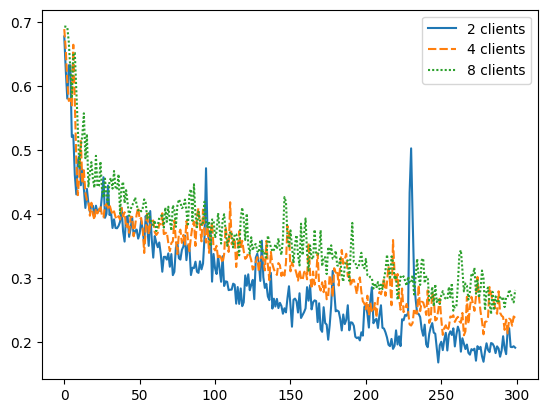

In [17]:
all_loss_clients_np = {key: value.detach().numpy() for key, value in all_loss_clients.items()}

df_loss_clients = pd.DataFrame(all_loss_clients_np)

ax = sns.lineplot(df_loss_clients)

#### State what impact (if any) adding more clients has on the loss and explain the observed pattern.

Adding more clients seems to increase the loss as the clients have less data to train on, there's a higher likelihood of poorer model performance, leading to an increase in loss.

## Question 3: Bridging VFL and generative modeling (8 points)

In this exercise, you'll explore how synthetic data can be generated when the data is constrained to be vertically partitioned. In this regard, combine VFL with variational autoencoders (VAEs) by following the architecture shown in the figure below. Each client uses a local network, i.e., a multi-layer perceptron (MLP) to embed its sensitive features into latents. These latents are concatenated at the server and passed through a VAE. The VAE produces synthetic latents which are partitioned and then converted back into the actual input space using another MLP. Code the necessary components using the templates from [lab-vfl.ipynb](https://github.com/lydiaYchen/DDL24Spring/blob/main/lab/lab-vfl.ipynb) and [generative_modeling.py](https://github.com/lydiaYchen/DDL24Spring/blob/main/lab/generative_modeling.py). Show the model's training progress per epoch. 

Scoring:
- _(1 point)_ Preprocess the dataset and partition the features similarly to the discriminative model VFL lab.
- _(2 points)_ Define the input & output MLP networks to be used by clients.
- _(2 points)_ Define the VAE used at the server over the concatenated feature representations from the clients.
- _(2 points)_ Define the VFL network that fits together the client networks and that of the server.
- _(1 point)_ Create and run the training loop of the complete model, printing the loss at every epoch.

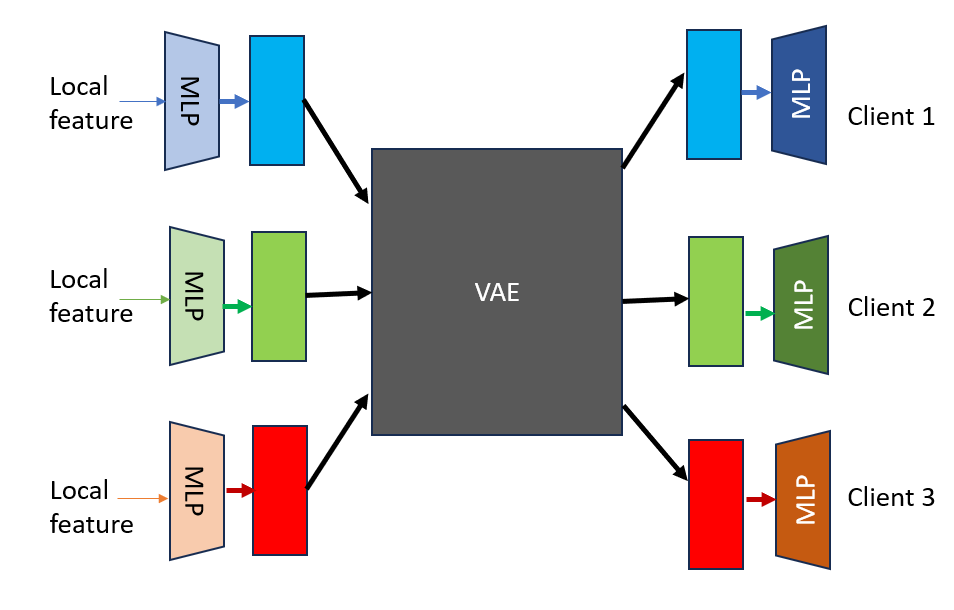





In [18]:
df = pd.read_csv("heart-dataset/heart.csv")
num_clients = 3

In [19]:
#Training configurations
EPOCHS = 300
BATCH_SIZE = 64
TRAIN_TEST_THRESH = 0.8

# model architecture hyperparameters
outs_per_client = 2
final_out_dims = 2

categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
numerical_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
df[numerical_cols] = MinMaxScaler().fit_transform(df[numerical_cols])  # scale numerical features for effective learning

In [20]:
class VFLBottomModel(nn.Module):
    def __init__(self, in_feat, out_feat):
        super(VFLBottomModel, self).__init__()
        self.local_out_dim = out_feat
        self.local_in_dim = in_feat

        #Encoder
        self.linear1 = nn.Linear(in_feat, out_feat)
        self.lin_bn1 = nn.BatchNorm1d(num_features=out_feat)
        self.linear2 = nn.Linear(out_feat, out_feat)
        self.lin_bn2 = nn.BatchNorm1d(num_features=out_feat)

        #Decoder
        self.linear3 = nn.Linear(out_feat, out_feat)
        self.lin_bn3 = nn.BatchNorm1d(num_features=out_feat)
        self.linear4 = nn.Linear(out_feat, in_feat)
        self.lin_bn4 = nn.BatchNorm1d(num_features=in_feat)

        
        self.act = nn.ReLU()
        self.dropout = nn.Dropout(0.1)

    def encode(self, x):
        lin1 = self.dropout(self.act(self.lin_bn1(self.linear1(x))))
        lin2 = self.act(self.lin_bn2(self.linear2(lin1)))
        return lin2

    def decode(self, z):
        lin3 = self.dropout(self.act(self.lin_bn3(self.linear3(z))))
        lin4 = self.act(self.lin_bn4(self.linear4(lin3)))
        return lin4


In [21]:
class Autoencoder(nn.Module):
    def __init__(self, D_in, H=50, H2=12, latent_dim=3):

        # Encoder
        super(Autoencoder, self).__init__()
        self.optimizer = None
        self.criterion = None
        self.linear1 = nn.Linear(D_in, H)
        self.lin_bn1 = nn.BatchNorm1d(num_features=H)
        self.linear2 = nn.Linear(H, H2)
        self.lin_bn2 = nn.BatchNorm1d(num_features=H2)
        self.linear3 = nn.Linear(H2, H2)
        self.lin_bn3 = nn.BatchNorm1d(num_features=H2)

        #         # Latent vectors mu and sigma
        self.fc1 = nn.Linear(H2, latent_dim)
        self.bn1 = nn.BatchNorm1d(num_features=latent_dim)
        self.fc21 = nn.Linear(latent_dim, latent_dim)
        self.fc22 = nn.Linear(latent_dim, latent_dim)

        #         # Sampling vector
        self.fc3 = nn.Linear(latent_dim, latent_dim)
        self.fc_bn3 = nn.BatchNorm1d(latent_dim)
        self.fc4 = nn.Linear(latent_dim, H2)
        self.fc_bn4 = nn.BatchNorm1d(H2)

        #         # Decoder
        self.linear4 = nn.Linear(H2, H2)
        self.lin_bn4 = nn.BatchNorm1d(num_features=H2)
        self.linear5 = nn.Linear(H2, H)
        self.lin_bn5 = nn.BatchNorm1d(num_features=H)
        self.linear6 = nn.Linear(H, D_in)
        self.lin_bn6 = nn.BatchNorm1d(num_features=D_in)

        self.relu = nn.ReLU()

    def encode(self, x):
        lin1 = self.relu(self.lin_bn1(self.linear1(x)))
        lin2 = self.relu(self.lin_bn2(self.linear2(lin1)))
        lin3 = self.relu(self.lin_bn3(self.linear3(lin2)))

        fc1 = F.relu(self.bn1(self.fc1(lin3)))

        r1 = self.fc21(fc1)
        r2 = self.fc22(fc1)

        return r1, r2

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        fc3 = self.relu(self.fc_bn3(self.fc3(z)))
        fc4 = self.relu(self.fc_bn4(self.fc4(fc3)))

        lin4 = self.relu(self.lin_bn4(self.linear4(fc4)))
        lin5 = self.relu(self.lin_bn5(self.linear5(lin4)))
        return self.lin_bn6(self.linear6(lin5))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

    def train_with_settings(self, epochs, batch_sz, real_data, optimizer, loss_fn):
        self.optimizer = optimizer
        self.criterion = loss_fn
        num_batches = len(real_data) // batch_sz if len(real_data) % batch_sz == 0 else len(real_data) // batch_sz + 1
        for epoch in range(epochs):
            self.optimizer.zero_grad()
            total_loss = 0.0
            for minibatch in range(num_batches):
                if minibatch == num_batches - 1:
                    minibatch_data = real_data[int(minibatch * batch_sz):]
                else:
                    minibatch_data = real_data[int(minibatch * batch_sz):int((minibatch + 1) * batch_sz)]

                outs, mu, logvar = self.forward(minibatch_data)
                loss = self.criterion(outs, minibatch_data, mu, logvar)
                total_loss += loss
                loss.backward()
                self.optimizer.step()

            print(f"Epoch: {epoch} Loss: {total_loss.detach().numpy() / num_batches:.3f}")

    def sample(self, nr_samples, mu, logvar):
        sigma = torch.exp(logvar / 2)
        no_samples = nr_samples
        q = torch.distributions.Normal(mu.mean(axis=0), sigma.mean(axis=0))
        z = q.rsample(sample_shape=torch.Size([no_samples]))
        with torch.no_grad():
            pred = self.decode(z).cpu().numpy()

        pred[:, -1] = np.clip(pred[:, -1], 0, 1)
        pred[:, -1] = np.round(pred[:, -1])
        return pred

class customLoss(nn.Module):
    def __init__(self):
        super(customLoss, self).__init__()
        self.mse_loss = nn.MSELoss(reduction="sum")

    def forward(self, x_recon, x, mu, logvar):
        loss_MSE = self.mse_loss(x_recon, x)
        loss_KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return loss_MSE + loss_KLD

In [22]:
class VFLVAENetwork(nn.Module):
    def __init__(self, local_models, D_in):
        super(VFLVAENetwork, self).__init__()
        self.num_cli = None  # the number of clients
        self.cli_features = None  # the set of features corresponding to a client
        self.bottom_models = local_models

        self.top_model = Autoencoder(D_in=D_in)

        self.optimizer = optim.AdamW(self.parameters())
        self.criterion = customLoss()

    def train_with_settings(self, epochs, batch_sz, n_cli, cli_features, x, y):
        self.num_cli = n_cli  
        self.cli_features = cli_features  
        x = x.astype('float32')
        y = y.astype('float32')
        x_train = [torch.tensor(x[feats].values) for feats in cli_features]
        y_train = torch.tensor(y.values)

        loss_list = torch.zeros(epochs)

        num_batches = len(x) // batch_sz if len(x) % batch_sz == 0 else len(x) // batch_sz + 1
        for epoch in range(epochs):
            self.optimizer.zero_grad()
            total_loss = 0.0
            correct = 0.0
            total = 0.0
            for minibatch in range(num_batches):
                if minibatch == num_batches - 1:
                    x_minibatch = [x[int(minibatch * batch_sz):] for x in x_train]
                    y_minibatch = y_train[int(minibatch * batch_sz):]
                else:
                    x_minibatch = [x[int(minibatch * batch_sz):int((minibatch + 1) * batch_sz)] for x in x_train]
                    y_minibatch = y_train[int(minibatch * batch_sz):int((minibatch + 1) * batch_sz)]

                concat_feature_representations = torch.tensor([])
                for i in range(n_cli):
                    concat_feature_representations = torch.cat((concat_feature_representations, x_minibatch[i]), dim=1)

                outs, mu, logvar = self.forward(x_minibatch) #
                pred = torch.argmax(outs, dim=1)
                actual = torch.argmax(y_minibatch, dim=1)
                correct += torch.sum((pred == actual))
                total += len(actual)
                loss = self.criterion(outs, concat_feature_representations, mu, logvar)
                total_loss += loss
                loss.backward()
                self.optimizer.step()
                
            loss_list[epoch] = total_loss / num_batches
            print(f"Epoch: {epoch} Train accuracy: {correct * 100 / total:.2f}% Loss: {total_loss.detach().numpy()/num_batches:.3f}") 
        return loss_list

    def forward(self, x):
        local_outs = torch.tensor([])
        for i in range(len(self.bottom_models)):
            client_output = self.bottom_models[i].encode(x[i])
            local_outs = torch.cat((local_outs, client_output), dim=1)

        top_model_out, mu, logvar = self.top_model(local_outs)

        client_outs = torch.tensor([])
        start_index = 0
        for i in range(len(self.bottom_models)):
            end_index = start_index + self.bottom_models[i].local_out_dim
            client_to_decode = top_model_out[:, start_index:end_index]
            client_decoded = self.bottom_models[i].decode(client_to_decode)
            client_outs = torch.cat((client_outs,client_decoded), dim=1)

        return client_outs, mu, logvar

    def test(self, x, y):
        x = x.astype('float32')
        y = y.astype('float32')
        x_test = [torch.tensor(x[feats].values) for feats in self.cli_features]
        y_test = torch.tensor(y.values)
        with torch.no_grad():
            outs = self.forward(x_test)
            preds = torch.argmax(outs, dim=1)
            actual = torch.argmax(y_test, dim=1)
            accuracy = torch.sum((preds == actual)) / len(actual)
            loss = self.criterion(outs, y_test)
            return accuracy, loss

In [23]:
X, Y = get_x_y(categorical_cols)

client_feature_names = partition_features(df=df,
                                          X=X,
                                          num_clients=num_clients,
                                          categorical_cols=categorical_cols,
                                          all_feature_names=all_feature_names)

X_train, X_test, Y_train, Y_test = train_test(X=X,
                                              Y=Y)

In [24]:
bottom_models = [VFLBottomModel(len(in_feats), outs_per_client * len(in_feats)) for in_feats in client_feature_names]

In [25]:
D_in = [bm.local_out_dim for bm in bottom_models]
D_in = sum(D_in)

In [26]:
VFLVAENetwork = VFLVAENetwork(bottom_models, D_in)

In [27]:
all_loss = VFLVAENetwork.train_with_settings(EPOCHS, BATCH_SIZE, num_clients,
                                client_feature_names, X_train, Y_train)

Epoch: 0 Train accuracy: 5.72% Loss: 967.639
Epoch: 1 Train accuracy: 5.72% Loss: 844.306
Epoch: 2 Train accuracy: 7.80% Loss: 783.018
Epoch: 3 Train accuracy: 4.87% Loss: 749.366
Epoch: 4 Train accuracy: 6.46% Loss: 717.891
Epoch: 5 Train accuracy: 4.99% Loss: 704.877
Epoch: 6 Train accuracy: 5.24% Loss: 683.590
Epoch: 7 Train accuracy: 6.33% Loss: 672.675
Epoch: 8 Train accuracy: 9.26% Loss: 678.408
Epoch: 9 Train accuracy: 6.09% Loss: 651.146
Epoch: 10 Train accuracy: 4.38% Loss: 654.139
Epoch: 11 Train accuracy: 3.41% Loss: 647.422
Epoch: 12 Train accuracy: 3.53% Loss: 639.737
Epoch: 13 Train accuracy: 4.87% Loss: 635.925
Epoch: 14 Train accuracy: 3.05% Loss: 642.949
Epoch: 15 Train accuracy: 2.44% Loss: 627.553
Epoch: 16 Train accuracy: 6.09% Loss: 628.558
Epoch: 17 Train accuracy: 5.72% Loss: 614.874
Epoch: 18 Train accuracy: 3.17% Loss: 613.878
Epoch: 19 Train accuracy: 3.29% Loss: 613.172
Epoch: 20 Train accuracy: 7.80% Loss: 609.289
Epoch: 21 Train accuracy: 3.90% Loss: 600.81